In [1]:
import numpy as np
import pandas as pd

from importlib import reload

import synthetic.render.generator as gen

import matplotlib.pyplot as plt
%matplotlib inline

import multiprocessing as mp

import sys
import os
import math
import logging
import time
import galsim
import fitsio as fio

import ngmix

import synthetic.render.render as render
import synthetic.render.icl as icl
import images

# simple image

In [2]:
catalog_path = '/e/ocean1/users/vargatn/DES/SIM_DATA/SKY_MODEL_EPSILON/res_clust_v2_z0l0/epsilon_clust_v8-z0l0_15000_000.fits'
data = fio.read(catalog_path)
catalog_cluster = data[data['LOC'] == 1]
catalog_field = data[data['LOC'] == 0]

In [10]:
catalog = np.hstack((catalog_cluster, catalog_field))

In [11]:
df = render.DrawField(5000, catalog, band="i")

In [17]:
df.prepare()
df.make_infodicts()
df.multi_render(100)
df.collate_stamps()

starting xshear calculations in 100 processes


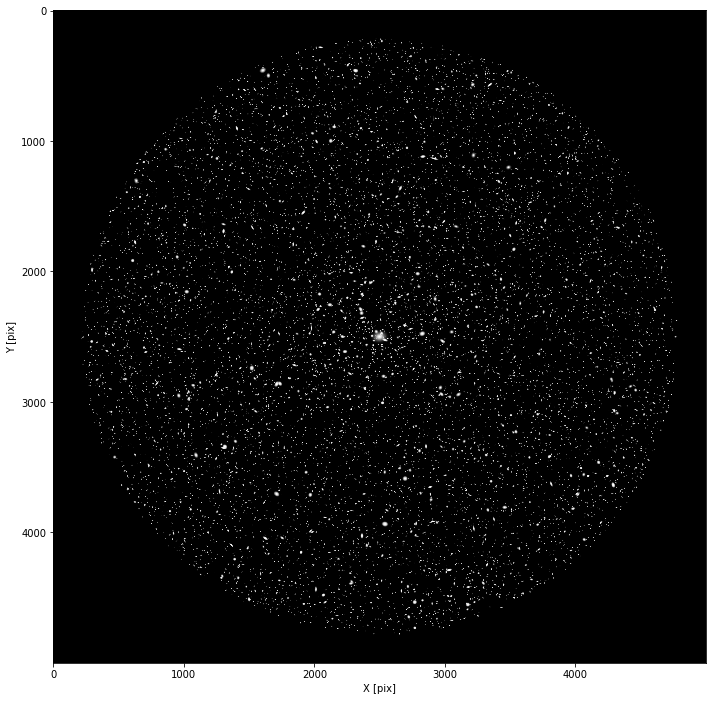

In [21]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
cc = df.canvas.array + 0.001
ax.imshow(np.arcsinh(cc) / cc, cmap=plt.cm.gray_r)
ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")
fig.savefig("example_full_no_noise.png", bbox_inches="tight")

# Estimate shear

In [207]:
class ExtractShear(object):
    def __init__(self, drawer):
        self.drawer = drawer
        self.raw_stamps = self.drawer.stamps
        self.image_epsf = self.drawer.image_epsf
        self.BADVAL = -9999
        
    def extract_stamps(self, size=32):
        self.stamps = []
        
        half_size = size // 2
        
        for i, stamp in enumerate(self.raw_stamps):
            bounds = stamp.bounds
            cen = bounds.center
            bb = galsim.bounds.BoundsI(cen.x - half_size,
                                       cen.x + half_size - 1,
                                       cen.y - half_size,
                                       cen.y + half_size - 1)
            self.stamps.append(self.drawer.canvas[bb])
    
    def estimate_shear(self, shear_est="KSB", which="canvas"):
        """
        shear modes = REGAUSS’, ‘LINEAR’, ‘BJ’, or ‘KSB’
        which is raw or canvas, default to canvas
        """
        
        stamps = self.raw_stamps
        if which == "canvas":
            stamps = self.stamps
        
        self.logs = []
        self.shears = []
        self.success = []
        self.fluxes = []
        self.shears_error = []
        for i, im in enumerate(stamps):
            try:
                res = galsim.hsm.EstimateShear(im, self.image_epsf, shear_est=shear_est, sky_var=0.0001)
                self.logs.append(res)
                
                tmp = np.array([res.corrected_g1, res.corrected_g2])
                
                self.shears.append(tmp)
                self.fluxes.append(res.moments_amp * (self.drawer.pixel_scale)**2)
                self.shears_error.append(res.corrected_shape_err)
                self.success.append(True)
#                 print("here")
            except:
                self.logs.append(None)
                self.fluxes.append(None)
                tmp = np.array([self.BADVAL, self.BADVAL])
                self.shears.append(tmp)
                self.shears_error.append(None)
                self.success.append(False)
                
                
               
        self.fluxes = np.array(self.fluxes)
        self.shears = np.array(self.shears)
        self.success = np.array(self.success)
        self.shears_error = np.array(self.shears_error)
        

## test catalogs

In [79]:
test_catalog = catalog.copy()
test_catalog["G1"] = 0.05
test_catalog["G2"] = 0.02

df = render.DrawField(5000, test_catalog, band="i")
df.prepare()
df.make_infodicts()
df.multi_render(100)
df.collate_stamps()


starting xshear calculations in 100 processes


In [107]:
es = ExtractShear(df)
es.extract_stamps()
es.estimate_shear(shear_est="KSB")

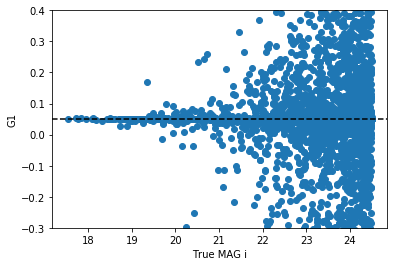

In [147]:
fig = plt.figure()
ax = fig.add_subplot(111)

val1 = test_catalog["MAG_I"][es.success]
val2 = es.shears[es.success, 0]
ax.scatter(val1, val2)
# ax.set_yscale("log")
ax.set_ylim(-0.3, 0.4)
ax.set_xlabel("True MAG i")
ax.axhline(0.05, color="black", ls="--")
ax.set_ylabel("G1")

fig.savefig("cluster_los_constant_shear_KSB_G1.png")

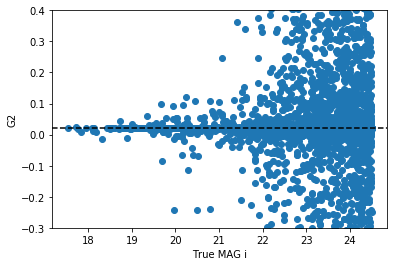

In [148]:
fig = plt.figure()
ax = fig.add_subplot(111)

val1 = test_catalog["MAG_I"][es.success]
val2 = es.shears[es.success, 1]
ax.scatter(val1, val2)
# ax.set_yscale("log")
ax.set_ylim(-0.3, 0.4)
ax.set_xlabel("True MAG i")
ax.axhline(0.02, color="black", ls="--")
ax.set_ylabel("G2")
fig.savefig("cluster_los_constant_shear_KSB_G2.png")

# Estimate realistic noise

In [23]:
es = ExtractShear(df)

In [24]:
es.extract_stamps()

2.509813
5.192254
8.36335
15.220351


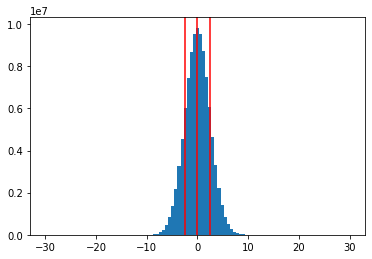

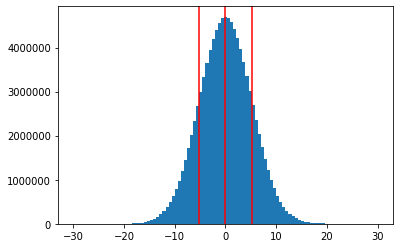

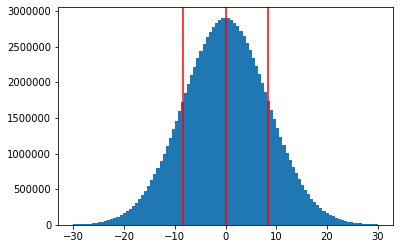

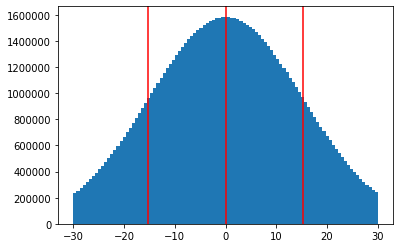

In [174]:
paths = [
    "/e/ocean1/users/vargatn/DES/SIM_DATA/output-cluster-res-z0l0-002-noise-example-0/y3v02/DES2122+0209/sources-g/OPS/multiepoch/Y3A1/r2601/DES2122+0209/p01/coadd/DES2122+0209_r2601p01_g.fits 
    "/e/ocean1/users/vargatn/DES/SIM_DATA/output-cluster-res-z0l0-002-noise-example-0/y3v02/DES2122+0209/sources-r/OPS/multiepoch/Y3A1/r2601/DES2122+0209/p01/coadd/DES2122+0209_r2601p01_r.fits",
    "/e/ocean1/users/vargatn/DES/SIM_DATA/output-cluster-res-z0l0-002-noise-example-0/y3v02/DES2122+0209/sources-i/OPS/multiepoch/Y3A1/r2601/DES2122+0209/p01/coadd/DES2122+0209_r2601p01_i.fits",
    "/e/ocean1/users/vargatn/DES/SIM_DATA/output-cluster-res-z0l0-002-noise-example-0/y3v02/DES2122+0209/sources-z/OPS/multiepoch/Y3A1/r2601/DES2122+0209/p01/coadd/DES2122+0209_r2601p01_z.fits",
]
for pp in paths:
    tmp = fio.read(pp)
    std = tmp[tmp < 50].flatten().std()
    print(std)
    
    bins = np.linspace(-30, 30, 100)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist(tmp.flatten(), bins=bins)
    ax.axvline(0, color="red")
    sigma = std
    ax.axvline(-sigma, color="red")
    ax.axvline(+sigma, color="red")
    None    

In [175]:
stds = np.array([2.509813, 5.192254, 8.36335, 15.220351])

In [177]:
dfs = []
for i, band in enumerate(["g", "r", "i", "z"]):
    df = render.DrawField(5000, catalog, band=band)
    
    df.prepare()
    df.make_infodicts()
    df.multi_render(100)
    df.collate_stamps()    
    dfs.append(df)

starting xshear calculations in 100 processes
starting xshear calculations in 100 processes
starting xshear calculations in 100 processes
starting xshear calculations in 100 processes


In [200]:
noises = []
for i, band in enumerate(["g", "r", "i", "z"]):
    noise = np.random.normal(scale=stds[i] / 2, size=(5000, 5000))
    noises.append(noise)

In [201]:
arrs = [
    dfs[0].canvas.array + noises[0],
    dfs[1].canvas.array + noises[1],
    dfs[2].canvas.array + noises[2],
]

0.9445038437843323


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


noised_render.png


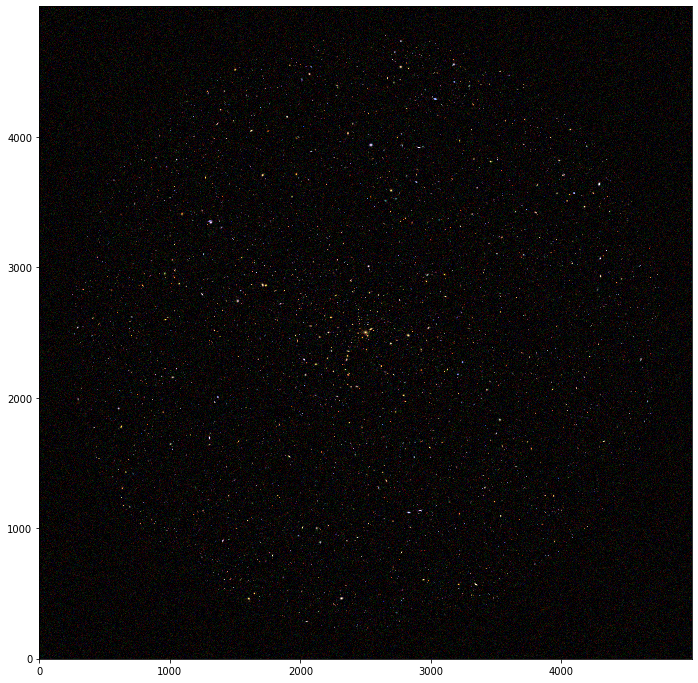

In [202]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
factor = 0.01
scales = np.array([1., 1.2, 2.5]) * factor
nonlinear = 0.12
clip = 0

pad = 0
obs_im = images.get_color_image(arrs[2] + pad,
                                arrs[1] + pad,
                                arrs[0] + pad,
                                nonlinear=nonlinear, clip=clip, scales=scales)  
print(obs_im.max())
ax.imshow(obs_im * 2, origin=3)
# fig.savefig("mock_clusters_z0l1_{:}.pdf", dpi=300, bbox_inches="tight")
fname = "noised_render.png"
print(fname)
fig.savefig(fname, dpi=300, bbox_inches="tight")

Text(0, 0.5, 'Y [pix]')

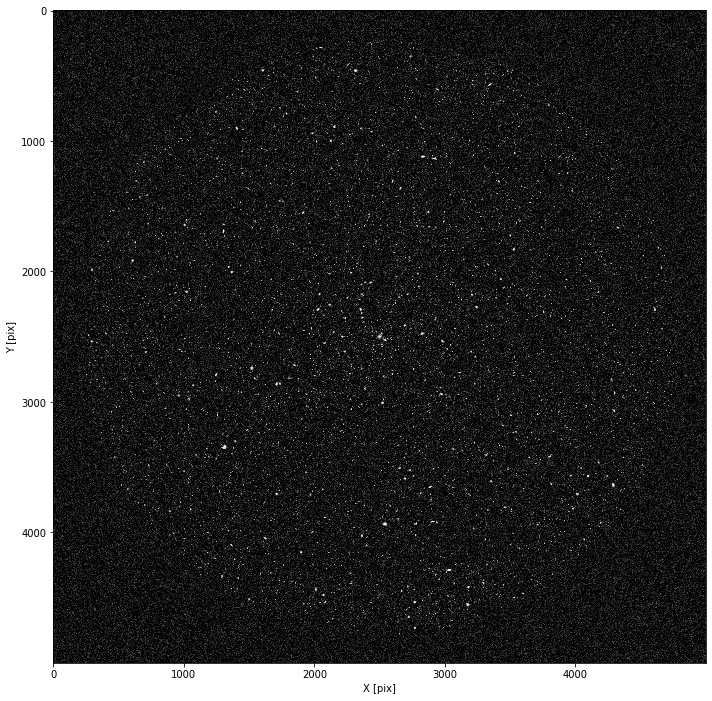

In [193]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
cc = dfs[0].canvas.array + noises[0]
ax.imshow(np.arcsinh(cc) / cc, cmap=plt.cm.gray_r)
ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")

In [203]:
galpath = "./ICL/evolving_red_gal.dat"
mstarpath = "./ICL/mstar_des_i03.fit"
jk_profile_root = "./ICL/jacknife_profiles_0.15_rand_back_subtracted_corZ_faintgalsub/jacknife_profile_"

bcg = {
    "size": 32.,
    "g1": 0.1356766444194723,
    "g2":-0.0345231539560347,
    "imag": 17.76,
    "color_gr": 1.36,
    "color_ri": 0.54,
    "color_iz": 0.32,
}
mass = 10**14.45
z = 0.3

In [205]:
di = icl.DrawICL(mass, z, bcg, galpath, mstarpath, jk_profile_root)
di.get_icl()
icl_arrs = [di.flux_g, di.flux_r, di.flux_i, di.flux_z]

0.9445538520812988


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


noised_render_icl.png


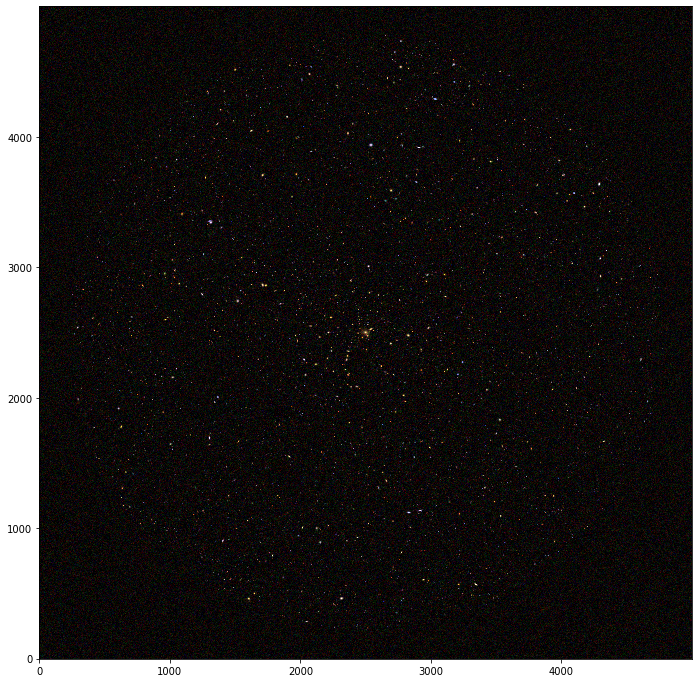

In [206]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
factor = 0.01
scales = np.array([1., 1.2, 2.5]) * factor
nonlinear = 0.12
clip = 0

pad = 0
obs_im = images.get_color_image(arrs[2] + icl_arrs[2] + pad,
                                arrs[1] + icl_arrs[1] + pad,
                                arrs[0] + icl_arrs[0] + pad,
                                nonlinear=nonlinear, clip=clip, scales=scales)  
print(obs_im.max())
ax.imshow(obs_im * 2, origin=3)
# fig.savefig("mock_clusters_z0l1_{:}.pdf", dpi=300, bbox_inches="tight")
fname = "noised_render_icl.png"
print(fname)
fig.savefig(fname, dpi=300, bbox_inches="tight")

In [151]:
path = "/e/ocean1/users/vargatn/DES/SIM_DATA/output-cluster-res-z0l0-002-noise-example-0/y3v02/DES2122+0209/sources-g/OPS/multiepoch/Y3A1/r2601/DES2122+0209/p01/coadd/DES2122+0209_r2601p01_g.fits"
tmp = fio.read(path)

In [166]:
tmp[tmp < 30].flatten().std()

2.4908426

In [167]:
tmp[tmp < 30].flatten().mean()

0.02914486

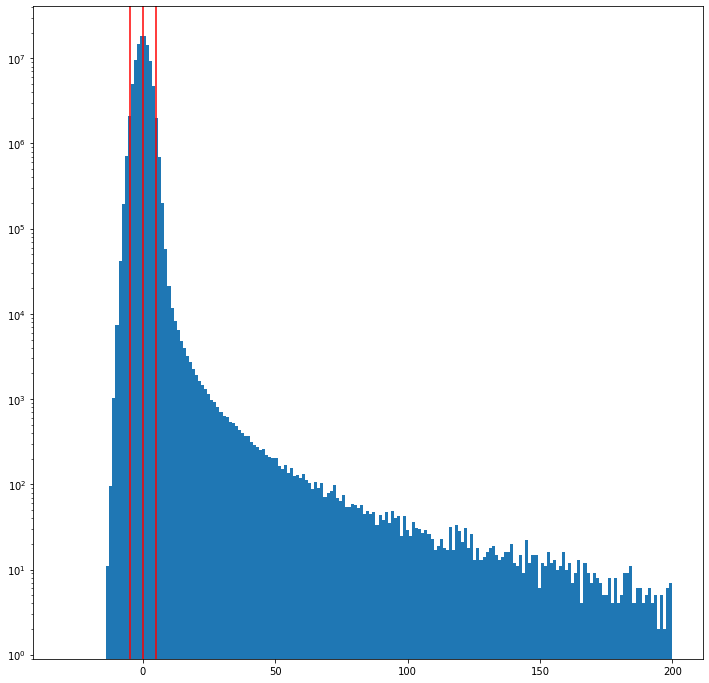

In [165]:
bins = np.linspace(-30, 200, 200)
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.hist(tmp.flatten(), bins=bins, log=True,)
ax.axvline(0, color="red")
sigma = 5
ax.axvline(-sigma, color="red")
ax.axvline(+sigma, color="red")
None

In [30]:
catalog_e1p = catalog.copy()
catalog_e1p["G1"] += 0.05
df = render.DrawField(5000, catalog, band="i")

catalog_e1m = catalog.copy()
catalog_e1m["G1"] -= 0.05

catalog_e2p = catalog.copy()
catalog_e2p["G2"] += 0.05

catalog_e2m = catalog.copy()
catalog_e2m["G2"] -= 0.05


In [ ]:
df = render.DrawField(5000, catalog, band="i")

Text(0, 0.5, '$\\delta$ MAG (measured - true) / true')

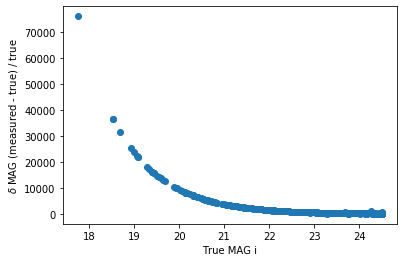

In [395]:
fig = plt.figure()
ax = fig.add_subplot(111)

val1 = catalog_cluster["MAG_I"][es.success]
val2 = np.abs(es.fluxes[es.success] - catalog_cluster["FLUX_I"][es.success]) #/ catalog_cluster["FLUX_I"][es.success]
ax.scatter(val1, val2)
# ax.set_yscale("log")
# ax.set_ylim(0.1, 10)
ax.set_xlabel("True MAG i")
ax.set_ylabel("$\delta$ MAG (measured - true) / true")



Text(0, 0.5, '$\\delta$ MAG (measured - true) / true')

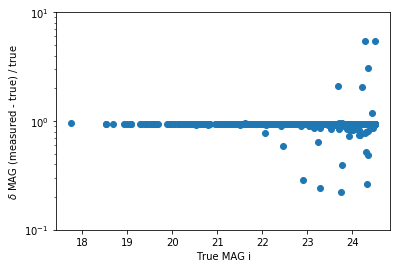

In [393]:
fig = plt.figure()
ax = fig.add_subplot(111)

val1 = catalog_cluster["MAG_I"][es.success]
val2 = np.abs(es.fluxes[es.success] - catalog_cluster["FLUX_I"][es.success]) / catalog_cluster["FLUX_I"][es.success]
ax.scatter(val1, val2)
ax.set_yscale("log")
ax.set_ylim(0.1, 10)
ax.set_xlabel("True MAG i")
ax.set_ylabel("$\delta$ MAG (measured - true) / true")



In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

val1 = catalog_cluster["MAG_I"][es.success]
val2 = ((catalog_cluster["G1"][es.success] - es.shears[es.success, 0])**2 +
        (catalog_cluster["G1"][es.success] - es.shears[es.success, 0])**2)
ax.scatter(val1, val2)
ax.set_yscale("log")
ax.set_xlim(17, 25)
ax.set_ylim(1e-10, 5)

(1e-10, 5)

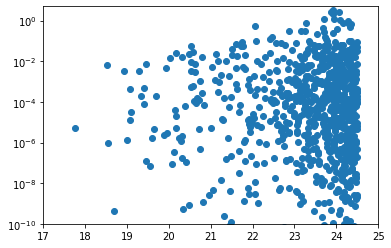

In [316]:
fig = plt.figure()
ax = fig.add_subplot(111)

val1 = catalog_cluster["MAG_I"][es.success]
val2 = ((catalog_cluster["G1"][es.success] - es.shears[es.success, 0])**2 +
        (catalog_cluster["G1"][es.success] - es.shears[es.success, 0])**2)
ax.scatter(val1, val2)
ax.set_yscale("log")
ax.set_xlim(17, 25)
ax.set_ylim(1e-10, 5)

array([-1.63169983e-03, -5.63644883e-02,  6.32017196e-03,  8.91331282e-04,
       -1.82799277e-04, -1.00728678e-02,  1.15160358e+01,  1.00680438e-01,
        5.02093972e-01,  9.63317879e-03,  2.14010161e-01, -1.76387054e-01,
       -1.32120176e-02,  2.16974982e-03, -1.07459089e-01, -5.91660015e-02,
       -5.83788126e-03,  5.02844210e-04,  1.25275387e-02,  1.54696920e-03,
       -1.63341317e-01,  3.92113881e-02, -8.81832733e-02, -8.34612827e-03,
       -2.78925429e-01,  7.26825427e-04, -4.90089828e-02,  5.05790565e-01,
       -9.53115763e-03,  2.02883195e-01,  1.04057278e-02,  2.12271032e-02,
       -4.56011994e-02, -1.80587006e-02, -3.96565772e-02, -1.18435315e-03,
       -1.08214102e-03, -1.81742486e-01, -9.69642298e-05, -2.75632675e-03,
        1.98959649e-04,  5.34799239e-03, -7.56304669e-01,  7.84322887e-02,
        8.98448361e-04,  2.99960179e-02,  1.11363762e-02,  3.30631316e-01,
        1.42391513e-01, -2.86193680e-01,  8.73022242e-03, -2.27443147e-01,
       -1.42860686e-05, -

In [260]:
es.logs

[galsim.hsm.ShapeData(image_bounds=galsim.BoundsI(xmin=2486, xmax=2517, ymin=2486, ymax=2517), moments_status=0, observed_shape=galsim.Shear((0.08010913750313417-0.020384835420361604j)), moments_sigma=2.863356828689575, moments_amp=36987.7734375, moments_rho4=2.4315312833538476, moments_n_iter=38, correction_status=0, corrected_g1=0.13730834424495697, corrected_g2=-0.0349375456571579, meas_type='g', corrected_shape_err=0.0, correction_method='KSB', resolution_factor=0.7340866923332214, psf_sigma=1.4765410423278809, psf_shape=galsim.Shear((-3.240654855574121e-09+1.7542138852633116e-09j))),
 galsim.hsm.ShapeData(image_bounds=galsim.BoundsI(xmin=2526, xmax=2557, ymin=2510, ymax=2541), moments_status=0, observed_shape=galsim.Shear((0.23016121845324083+0.21904932330255178j)), moments_sigma=3.0635175704956055, moments_amp=32498.427734375, moments_rho4=2.1960395113700804, moments_n_iter=25, correction_status=0, corrected_g1=0.3742298185825348, corrected_g2=0.3559943437576294, meas_type='g', c

In [247]:
es.shears

array([[-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999]])

In [165]:
es.stamps[0].array.shape

(16, 16)

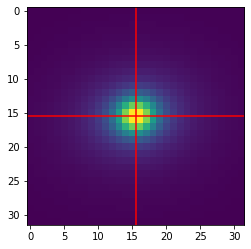

In [161]:
plt.imshow(es.stamps[0].array)
plt.axhline(15.5, color="red")
plt.axvline(15.5, color="red")